In [3]:
!qbraid jobs enable amazon_braket

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

from braket.aws import AwsDevice
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from quera_ahs_utils.plotting import show_global_drive, show_register
from quera_ahs_utils.drive import get_drive 

from iquhack_utils import find_UDG_radius, visualize_graph, get_blockade_radius, get_graph_from_blockade_radius, C6, save_result_json, open_json

from utils import postprocess_MIS, analysis_MIS

In [2]:
plt.rcParams['figure.dpi'] = 140

In [3]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

C6 = float(capabilities.rydberg.dict()['c6Coefficient']) # rad m^6/sec

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [4]:
def lieb_lattice(num_rows=1, num_columns=1):
    points = []
    
    for x in range(1, (num_columns + 1) * 2, 2):
        for y in range(1, (num_rows + 1) * 2, 2):
            center = np.array([x, y])
            points.append(center)
            points.append(center + np.array([0, 1]))
            points.append(center + np.array([0, -1]))
            points.append(center + np.array([1, 0]))
            points.append(center + np.array([-1, 0]))
    
    points = np.unique(np.array(points), axis=0)
    
    return points

# Points: 100


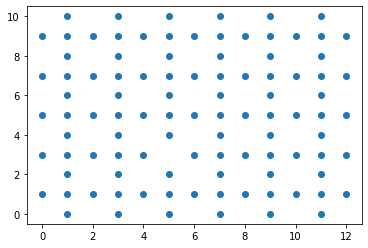

In [5]:
points = lieb_lattice(num_rows=4, num_columns=5)
points = np.delete(points, 40, axis=0)

# print(f"Points: {points}")
print(f"# Points: {len(points)}")
plt.scatter(*zip(*(points)))
plt.show()

Blockade Radius: 6.385e-06m
Unit Disk Radius: 1.030


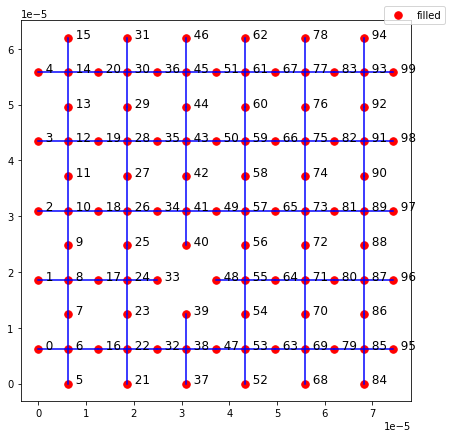

In [6]:
detuning_final = 80e6 # rad/sec
unitdisk_radius = 1.03 # 1 —> sqrt2
# Find blockade radius
blockade_radius = get_blockade_radius(detuning_final, 0) # no rabi amplitude at the end
print('Blockade Radius: {:0.3e}m'.format(blockade_radius))
print('Unit Disk Radius: {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius
# Generate the atom register
register = AtomArrangement()
for x in points:
    register.add((a * np.array(x)).round(7))

# print(register)
show_register(register, blockade_radius = blockade_radius)

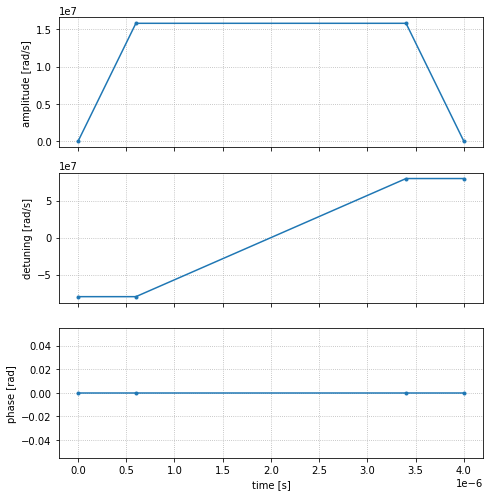

In [7]:
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 15.8e6  # rad / sec

# Define the strength of the detuning Δ
detuning_initial = -detuning_final     # rad / sec
detuning_final = detuning_final # Defined above

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_initial, detuning_initial, detuning_final, detuning_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [8]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

In [12]:
# raise BaseException("Only run this cell when you are ready to submit your job.")
# DO NOT RUN THIS UNLESS YOU ARE SURE
nshots = 10
task = qpu.run(ahs_program, shots=nshots)
print(task)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:592242689881:quantum-task/1afe8f23-476c-4f14-a133-927e8c0ca748')


In [ ]:
result = task.result()
save_result_json("r=1.03, df=80e6, a=15.8, nshots=10, trial=1.json", result)

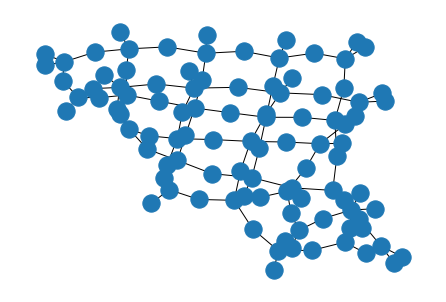

In [9]:
graph, _ = get_graph_from_blockade_radius(register, blockade_radius)
nx.draw(graph)

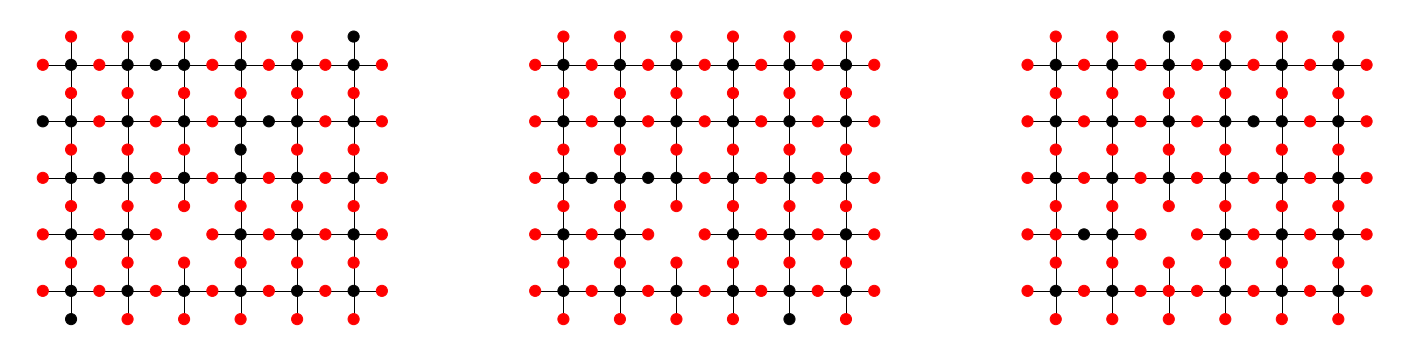

In [13]:
filename = "r=1.03, df=80e6, a=15.8.json"
result_json = open_json(filename)
num_measurements = len(result_json["measurements"])
sequences = [result_json["measurements"][i]["post_sequence"] for i in [0,num_measurements-2,num_measurements-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[sequences[i][j]] for j in range(len(sequences[i]))]
    visualize_graph(ax, graph, points, node_colors = seqs_color)
plt.show()

Average pre-processed size:  65.2700
Average post-processed IS size: 65.3333


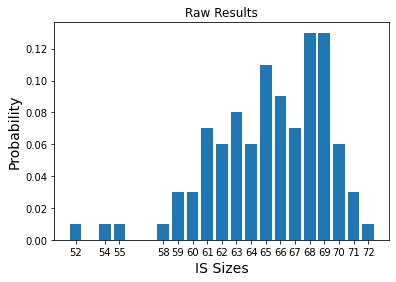

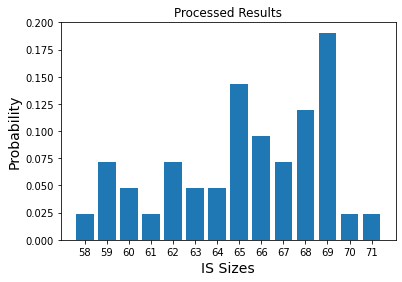

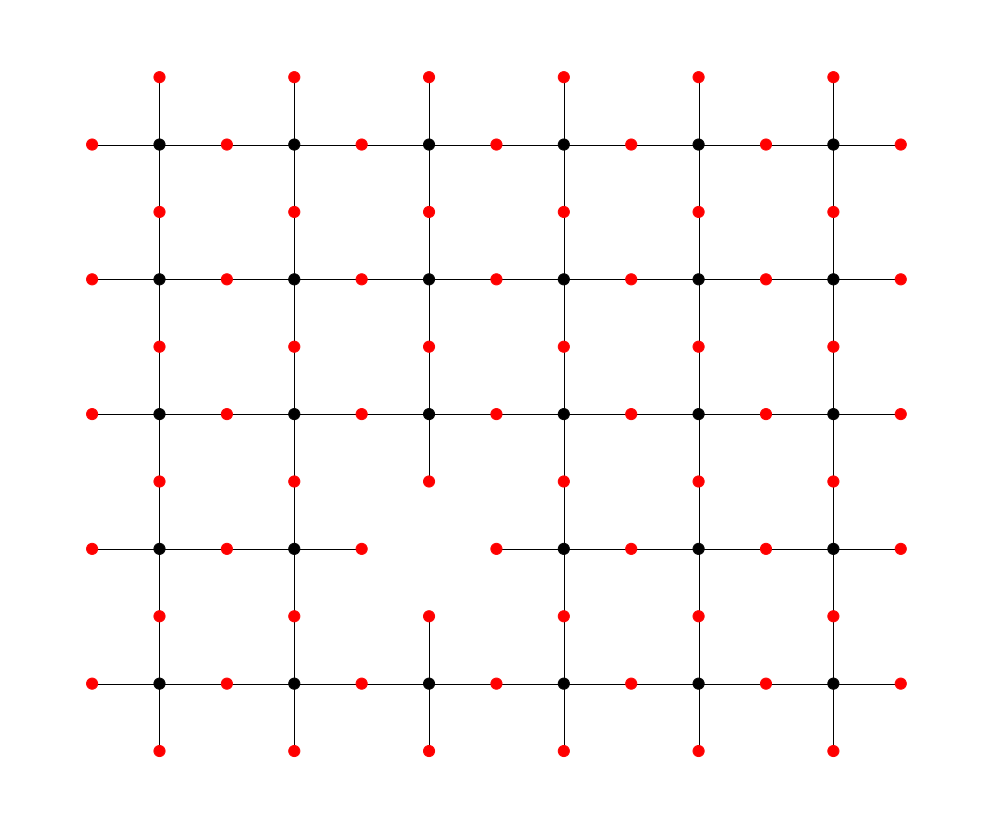

In [37]:
IS_sizes,pp_bitstrings = analysis_MIS(graph, result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = min(len(ind),1)

figure = plt.figure(figsize=(25,15))
for i in range(n_show):
    axes = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(axes, graph, {a: points[a] for a in range(len(points))}, node_colors = seqs_color)
    
    # print(np.where(pp_bitstrings[ind[i]]==0)[0])
    # print(seqs_color)
    
plt.show()

array([ 1.38095238,  4.21428571,  2.85714286,  1.45238095,  4.42857143,
        3.        ,  3.04761905,  9.28571429,  6.28571429,  4.78571429,
        8.0952381 , 13.14285714,  1.66666667,  1.69047619])

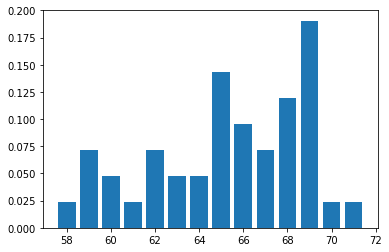

In [55]:
unorm_hist = pp_bitstrings.sum(axis=0)
norm_hist = unorm_hist / unorm_hist.sum()
# plt.bar(list(range(100)), norm_hist.cumsum())
IS_sizes_keys, IS_counts = np.unique(IS_sizes,return_counts=True)
IS_prob = IS_counts / IS_counts.sum()
IS_CDF = IS_prob.cumsum()
plt.bar(IS_sizes_keys, np.hstack([IS_CDF[0:1], np.diff(IS_prob.cumsum())]))
# plt.bar(IS_sizes_keys,  IS_prob)
IS_sizes_keys * IS_prob

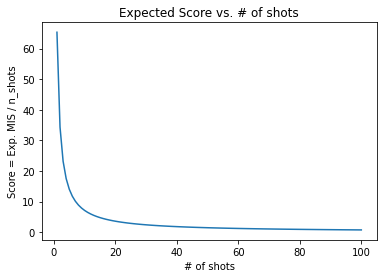

In [65]:
score_EVs = []
for n_shots in range(1,101):
    IS_max_CDF = IS_CDF ** n_shots
    IS_max_PDF = np.hstack([IS_CDF[0:1], np.diff(IS_max_CDF)])
    IS_max_EV = (IS_sizes_keys * IS_max_PDF).sum()
    score_EV = IS_max_EV / n_shots
    score_EVs.append(score_EV)
plt.plot(list(range(1,101)), score_EVs)
plt.title("Expected Score vs. # of shots")
plt.xlabel("# of shots")
plt.ylabel("Score = Exp. MIS / n_shots")
# fig = plt.figure()
# fig.patch.set_facecolor('#FFFFFF')
plt.savefig("EVScore.png")
plt.show()

Average pre-processed size:  43.6200
Average post-processed IS size: 42.6250


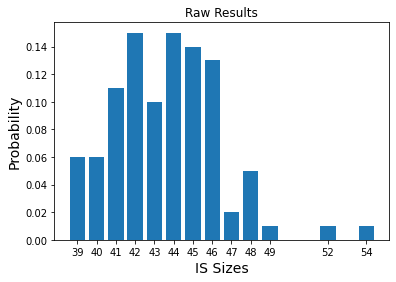

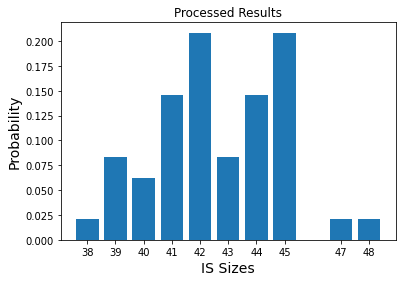

Average pre-processed size:  43.0800
Average post-processed IS size: 42.3966


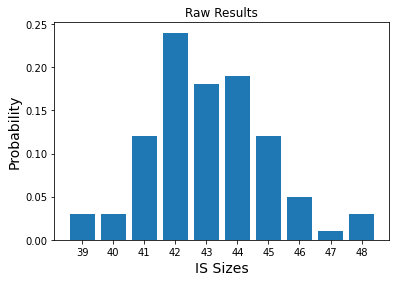

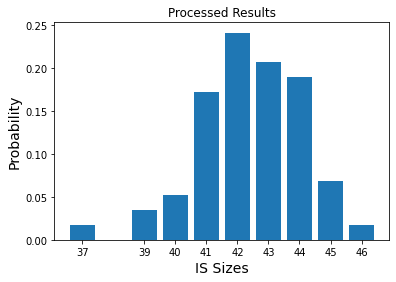

Average pre-processed size:  43.1300
Average post-processed IS size: 42.3273


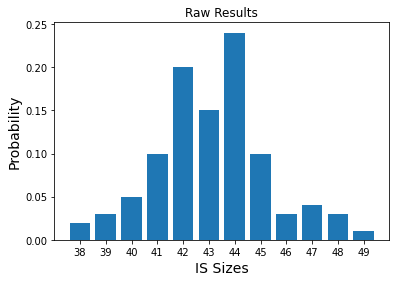

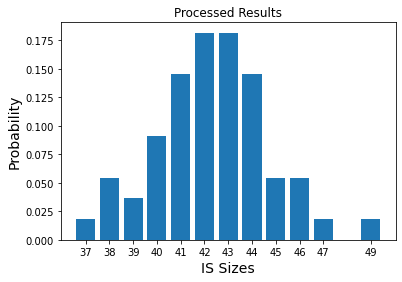

Average pre-processed size:  43.1000
Average post-processed IS size: 42.0851


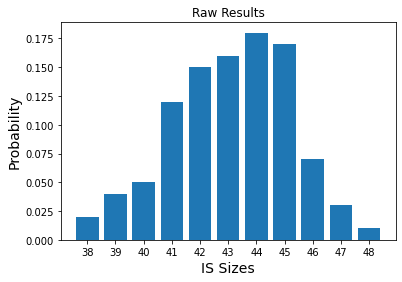

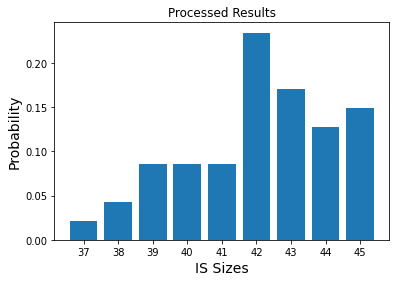

Average pre-processed size:  42.6900
Average post-processed IS size: 42.0645


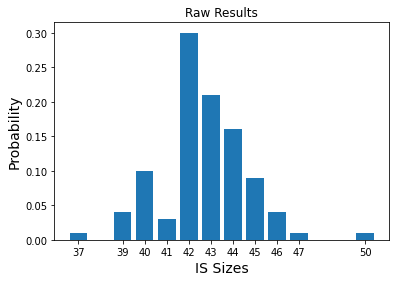

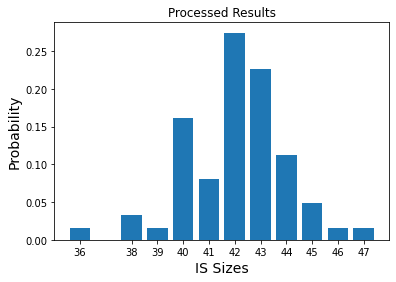

Average pre-processed size:  42.4100
Average post-processed IS size: 42.0714


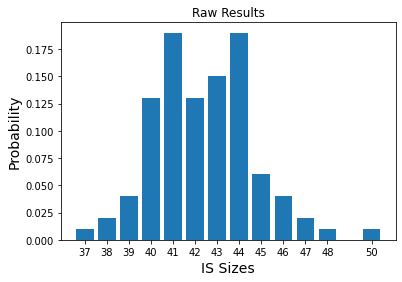

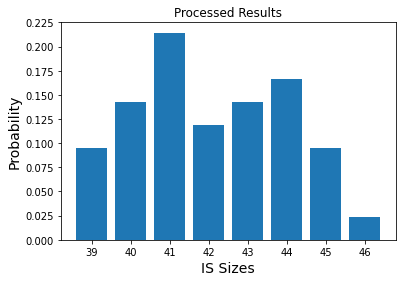

Average pre-processed size:  42.5100
Average post-processed IS size: 41.5745


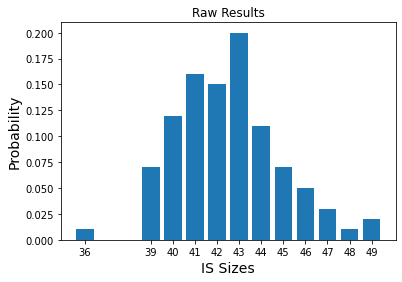

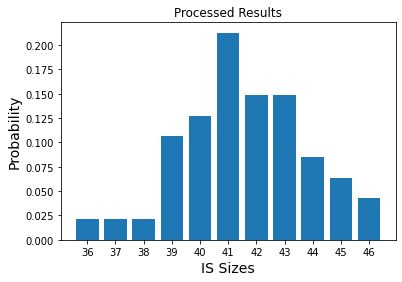

In [12]:
for df in [40, 45, 50, 55, 60, 70, 80]:
    filename = f"r=sqrt(sqrt(2)), df={df}e6.json"
    result_json = open_json(filename)

    IS_sizes,pp_bitstrings = analysis_MIS(graph, result_json)

    # ind, = np.where(IS_sizes==IS_sizes.max())
    # n_show = min(len(ind),1)

#     figure = plt.figure(figsize=(25,15))
#     for i in range(n_show):
#         axes = plt.subplot(1,n_show,i+1)

#         color_lookup = {0:"r",1:'k'}
#         seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
#         visualize_graph(axes, graph, {a: points[a] for a in range(len(points))}, node_colors = seqs_color)

#     plt.show()